## Loading data

In [115]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [116]:
def load_data(file_path):
    columns = ['Word', 'POS', 'Chunk', 'Tag']

    with open(file_path, 'r') as file:
        rows = []
        sentence_index = 1  # Start sentence indexing
        for line in file:
            if line.startswith('-DOCSTART-') or line.strip() == '':  # Skip doc starts and empty lines
                sentence_index += 1
                continue
            parts = line.strip().split()
            parts.append(sentence_index)  # Append the sentence index to each word entry
            rows.append(parts)

    data = pd.DataFrame(rows, columns=columns + ['Sentence #'])
    return data


In [117]:
train = load_data("../data/eng.train")
testa = load_data("../data/eng.testa")
testb = load_data("../data/eng.testb")

## Testing REGEXP performance for NER

In [118]:
import re
regex = r"[A-Z]+[^ ,.]*"

def regexp_pred(df):
    pred = [1 if re.search(regex,str(df['Word'][i])) else 0 for i in range(len(df))]
    return np.array(pred)

def true_labels(df):
    true = [1 if df['Tag'][i] == 'I-PER' else 0 for i in range(len(df))]
    return np.array(true)

In [119]:
train_pred = regexp_pred(train)
testa_pred = regexp_pred(testa)
testb_pred = regexp_pred(testb)

train_true = true_labels(train)
testa_true = true_labels(testa)
testb_true = true_labels(testb)

In [120]:
from sklearn.metrics import accuracy_score, recall_score, f1_score

def calculate_metrics(true_labels, predictions):
    accuracy = accuracy_score(true_labels, predictions)
    recall = recall_score(true_labels, predictions, average='macro')  # Use 'macro' for multi-class classification
    f1 = f1_score(true_labels, predictions, average='macro')  # Use 'macro' to treat all classes equally

    return accuracy, recall, f1


In [121]:
train_accuracy, train_recall, train_f1 = calculate_metrics(train_true, train_pred)
testa_accuracy, testa_recall, testa_f1 = calculate_metrics(testa_true, testa_pred)
testb_accuracy, testb_recall, testb_f1 = calculate_metrics(testb_true, testb_pred)

print("Train Metrics - Accuracy: {:.2f}, Recall: {:.2f}, F1 Score: {:.2f}".format(train_accuracy, train_recall, train_f1))
print("Testa Metrics - Accuracy: {:.2f}, Recall: {:.2f}, F1 Score: {:.2f}".format(testa_accuracy, testa_recall, testa_f1))
print("Testb Metrics - Accuracy: {:.2f}, Recall: {:.2f}, F1 Score: {:.2f}".format(testb_accuracy, testb_recall, testb_f1))

Train Metrics - Accuracy: 0.83, Recall: 0.91, F1 Score: 0.65
Testa Metrics - Accuracy: 0.84, Recall: 0.91, F1 Score: 0.67
Testb Metrics - Accuracy: 0.82, Recall: 0.90, F1 Score: 0.65


## Using RNNS for classification

Cleaning data

In [122]:
def clean_word(word):
    word = word.lower()
    word = re.sub(r'\d+', '<num>', word) # Special token <num> for numbers
    word = re.sub(r'[^\w<>\s]', '', word)  # \w matches alphanumeric characters and underscore, \s with spaces
    
    return word

print(clean_word("Year 2026$!!"))

year <num>


In [123]:
def clean_data(data):
    data_copy = data.copy()
    data_copy['Word'] = data_copy['Word'].apply(clean_word)
    return data_copy

In [124]:
clean_train = clean_data(train)
clean_testa = clean_data(testa)
clean_testb = clean_data(testb)

Vocabulary class, with special tokens for padding and out-of-vocabulary words

In [125]:
class Vocabulary:
    def __init__(self, data):
        self.words = ['<PAD>'] + ['<OOV>'] + sorted(set(data['Word']))
        self.word_to_index = {word: i for i, word in enumerate(self.words)}
        self.index_to_word = {i: word for i, word in enumerate(self.words)}

    def size(self):
        return len(self.words)
    
    def word_index(self, word):
        return self.word_to_index.get(word, 1) # Return 1 (index of <OOV>) if word outside vocabulary

    def index_word(self, index):
        return self.index_to_word.get(index, None) 


Extracting sentences from the dataframe

In [126]:
def extract_sentences(df):
    sentences = df.groupby('Sentence #')['Word'].apply(list).tolist()
    return sentences

In [127]:
train_sentences = extract_sentences(clean_train)
testa_sentences = extract_sentences(clean_testa)
testb_sentences = extract_sentences(clean_testb)

print(train_sentences[:10])

[['eu', 'rejects', 'german', 'call', 'to', 'boycott', 'british', 'lamb', ''], ['peter', 'blackburn'], ['brussels', '<num><num><num>'], ['the', 'european', 'commission', 'said', 'on', 'thursday', 'it', 'disagreed', 'with', 'german', 'advice', 'to', 'consumers', 'to', 'shun', 'british', 'lamb', 'until', 'scientists', 'determine', 'whether', 'mad', 'cow', 'disease', 'can', 'be', 'transmitted', 'to', 'sheep', ''], ['germany', 's', 'representative', 'to', 'the', 'european', 'union', 's', 'veterinary', 'committee', 'werner', 'zwingmann', 'said', 'on', 'wednesday', 'consumers', 'should', 'buy', 'sheepmeat', 'from', 'countries', 'other', 'than', 'britain', 'until', 'the', 'scientific', 'advice', 'was', 'clearer', ''], ['', 'we', 'do', 'nt', 'support', 'any', 'such', 'recommendation', 'because', 'we', 'do', 'nt', 'see', 'any', 'grounds', 'for', 'it', '', '', 'the', 'commission', 's', 'chief', 'spokesman', 'nikolaus', 'van', 'der', 'pas', 'told', 'a', 'news', 'briefing', ''], ['he', 'said', 'fur

Getting useful metrics regarding sentences

Mean length:  14.501887329962253
Standard variation:  11.602342778538238
Median:  10.0
Number of sentences above 20 words: 27377, or 0.2785414144291717%


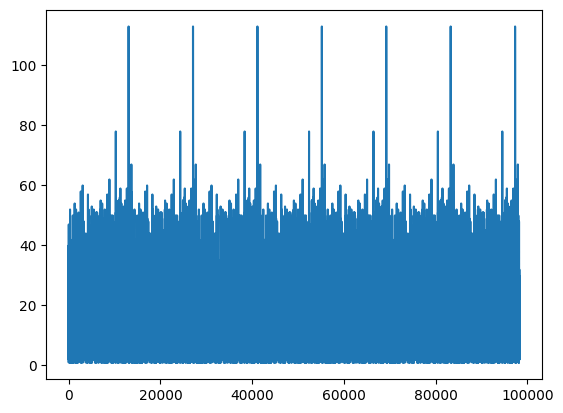

In [152]:
sentence_lengths = np.array([len(sentence) for sentence in train_sentences])
print("Mean length: ", sentence_lengths.mean())
print("Standard variation: ", sentence_lengths.std())
print("Median: ", np.median(sentence_lengths))
maxlen = 20
truncated = len([0 for sentence in train_sentences if len(sentence) > maxlen])
print(f"Number of sentences above {maxlen} words: {truncated}, or {truncated/len(train_sentences)}%")

plt.plot(np.arange(0,len(sentence_lengths)), sentence_lengths)
plt.show()

Vectorizing sentences

In [153]:
def sentence_to_indices(sentence, vocab):
    return [vocab.word_index(word) for word in sentence]

In [154]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

def pad_sentences(sentences, padding='post', maxlen=None):
    return pad_sequences(sentences, padding=padding, maxlen=maxlen)


In [155]:
vocab = Vocabulary(clean_train)
print(vocab.index_to_word.items())

dict_items([(0, '<PAD>'), (1, '<OOV>'), (2, ''), (3, '<num>'), (4, '<num><num>'), (5, '<num><num><num>'), (6, '<num><num><num><num>'), (7, '<num><num><num><num><num>'), (8, '<num><num><num>yr'), (9, '<num><num>a'), (10, '<num><num>acre'), (11, '<num><num>b'), (12, '<num><num>c'), (13, '<num><num>f'), (14, '<num><num>hectare'), (15, '<num><num>km'), (16, '<num><num>m'), (17, '<num><num>nd'), (18, '<num><num>p'), (19, '<num><num>percent'), (20, '<num><num>r'), (21, '<num><num>seat'), (22, '<num><num>strong'), (23, '<num><num>student'), (24, '<num><num>th'), (25, '<num><num>yr'), (26, '<num>a'), (27, '<num>all'), (28, '<num>ama'), (29, '<num>anhour'), (30, '<num>ashare'), (31, '<num>aug<num>'), (32, '<num>b'), (33, '<num>ball'), (34, '<num>c'), (35, '<num>cc'), (36, '<num>cent'), (37, '<num>club'), (38, '<num>d'), (39, '<num>day'), (40, '<num>foot'), (41, '<num>for<num>'), (42, '<num>game'), (43, '<num>hour'), (44, '<num>inch'), (45, '<num>inning'), (46, '<num>iron'), (47, '<num>jan<num>'

In [156]:
train_sentences_indices = [sentence_to_indices(sentence, vocab) for sentence in train_sentences]
train_padded_sentences = pad_sentences(train_sentences_indices, maxlen=maxlen)

testa_sentences_indices = [sentence_to_indices(sentence, vocab) for sentence in testa_sentences]
testa_padded_sentences = pad_sentences(testa_sentences_indices, maxlen=maxlen)

testb_sentences_indices = [sentence_to_indices(sentence, vocab) for sentence in testb_sentences]
testb_padded_sentences = pad_sentences(testb_sentences_indices, maxlen=maxlen)

In [157]:
print(train_padded_sentences[0])

[ 5050 12570  6141  2275 15528  1965  2066  8452     2     0     0     0
     0     0     0     0     0     0     0     0]


Preparing label sequences

In [158]:
import numpy as np
import pandas as pd

def prepare_labels_from_df(df, padding_label=0, maxlen=None):
    grouped = df.groupby('Sentence #')['Tag'].apply(list)
    
    if maxlen is None:
        maxlen = max(grouped.apply(len))
    
    label_sequences = []
    
    for tags in grouped:
        label_sequence = [1 if tag == 'I-PER' else 0 for tag in tags]
        label_sequence = label_sequence[:maxlen]
        label_sequence += [padding_label] * (maxlen - len(label_sequence))
        label_sequences.append(label_sequence)
    
    return np.array(label_sequences)


In [159]:
train_labels = prepare_labels_from_df(clean_train, maxlen=maxlen)
testa_labels = prepare_labels_from_df(clean_testa, maxlen=len(train_labels[0]))
testb_labels = prepare_labels_from_df(clean_testb, maxlen=len(train_labels[0]))

In [160]:
print(train_labels[1])

[1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Building model architecture

In [161]:
import tensorflow as tf
from tensorflow.keras.layers import Masking, Embedding, SimpleRNN, TimeDistributed

def build_model(vocab_size, embedding_dim, rnn_units, output_units):
    model = tf.keras.Sequential([
        Embedding(input_dim=vocab_size, output_dim=embedding_dim, mask_zero=True),  # Enable masking in the embedding layer, to ignore padding during training
        Masking(mask_value=0),
        SimpleRNN(rnn_units, return_sequences=True),
        TimeDistributed(tf.keras.layers.Dense(output_units, activation='sigmoid'))
    ])
    return model


In [162]:
vocab_size = vocab.size()  # Vocabulary size
embedding_dim = 64 
rnn_units = 128  # Number of units in RNN
output_units = 1  # Binary classification

model = build_model(vocab_size, embedding_dim, rnn_units, output_units)

model.summary()

Model: "sequential_107"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_107 (Embedding)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ masking_54 (Masking)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_107 (SimpleRNN)      │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_107            │ ?                      │   0 (unbuilt) │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Preparing batches for training and validation

In [163]:
train_labels = np.expand_dims(train_labels, axis=-1) 
testa_labels = np.expand_dims(testa_labels, axis=-1) 
testb_labels = np.expand_dims(testb_labels, axis=-1) 

train_dataset = tf.data.Dataset.from_tensor_slices((train_padded_sentences, train_labels))
train_dataset = train_dataset.batch(32)

testa_dataset = tf.data.Dataset.from_tensor_slices((testa_padded_sentences, testa_labels))
testa_dataset = testa_dataset.batch(32)

testb_dataset = tf.data.Dataset.from_tensor_slices((testb_padded_sentences, testb_labels))
testb_dataset = testb_dataset.batch(32)

Adjusting learning rate through a learning rate range test

In [164]:
def controlled_tweak_learning_rate(dataset, model_fn, vocab, embedding_dim, rnn_units, learning_rates, epochs_per_lr=1):
    losses = []
    lrs = []
    
    for lr in learning_rates:
        model = model_fn(vocab.size(), embedding_dim,rnn_units,output_units)  # Rebuild model to reset weights
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
        model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', 'recall'])
        history = model.fit(dataset, epochs=epochs_per_lr)
        
        # Append average loss over epochs for current learning rate
        avg_loss = np.mean(history.history['loss'])
        losses.append(avg_loss)
        lrs.append(lr)
        
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.semilogx(lrs, losses)
    plt.xlabel("Learning Rate")
    plt.ylabel("Average Loss")
    plt.title("Learning Rate vs. Average Loss")
    plt.grid(True)
    plt.show()
    
    return losses

300/300 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.4999 - loss: 0.6916 - recall: 0.4136
300/300 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.6314 - loss: 0.6815 - recall: 0.4643
300/300 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.6739 - loss: 0.6747 - recall: 0.4800
300/300 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.3156 - loss: 0.7250 - recall: 0.5042
300/300 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.6260 - loss: 0.6818 - recall: 0.5052
300/300 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.5627 - loss: 0.6857 - recall: 0.4045
300/300 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.6918 - loss: 0.6616 - recall: 0.4520
300/300 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.8268 - loss: 0.5780 - recall: 0.2955
300/300 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.8407 - loss: 0.4719 - recall: 0.2361
300/300 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.8690 - loss: 0.3895 - recall: 0.1692
300/300 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.9180 - loss: 0

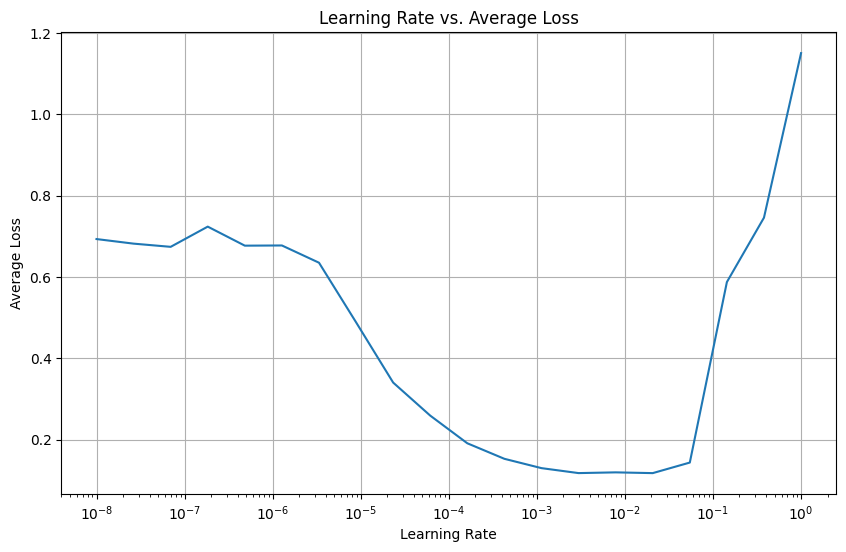

[0.6930302977561951,
 0.6817797422409058,
 0.6739139556884766,
 0.7236074805259705,
 0.6768014430999756,
 0.6772748827934265,
 0.6348745822906494,
 0.4883531332015991,
 0.34018591046333313,
 0.25892385840415955,
 0.19090981781482697,
 0.1527092605829239,
 0.12979775667190552,
 0.11759205162525177,
 0.11939787864685059,
 0.11753233522176743,
 0.14349959790706635,
 0.5873068571090698,
 0.745650053024292,
 1.1502139568328857]

In [165]:
def get_subset(dataset, subset_size=100):
    return dataset.take(subset_size)

reduced_set = get_subset(train_dataset, 300)

# Now perform the learning rate test on the reduced dataset
controlled_tweak_learning_rate(reduced_set, build_model, vocab, embedding_dim, rnn_units, np.logspace(start=-8,stop=0,num=20,base=10))

Training the model

In [166]:
model = build_model(vocab_size, embedding_dim, rnn_units, output_units)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy','recall'])

model.fit(train_dataset, epochs=10)


Epoch 1/10
3072/3072 ━━━━━━━━━━━━━━━━━━━━ 43s 13ms/step - accuracy: 0.9762 - loss: 0.0854 - recall: 0.4925
Epoch 2/10
3072/3072 ━━━━━━━━━━━━━━━━━━━━ 38s 12ms/step - accuracy: 0.9857 - loss: 0.0512 - recall: 0.6646
Epoch 3/10
3072/3072 ━━━━━━━━━━━━━━━━━━━━ 37s 12ms/step - accuracy: 0.9847 - loss: 0.0535 - recall: 0.6561
Epoch 4/10
3072/3072 ━━━━━━━━━━━━━━━━━━━━ 39s 13ms/step - accuracy: 0.9834 - loss: 0.0593 - recall: 0.6283
Epoch 5/10
3072/3072 ━━━━━━━━━━━━━━━━━━━━ 42s 14ms/step - accuracy: 0.9834 - loss: 0.0603 - recall: 0.6258
Epoch 6/10
3072/3072 ━━━━━━━━━━━━━━━━━━━━ 42s 14ms/step - accuracy: 0.9839 - loss: 0.0595 - recall: 0.6317
Epoch 7/10
3072/3072 ━━━━━━━━━━━━━━━━━━━━ 42s 14ms/step - accuracy: 0.9844 - loss: 0.0582 - recall: 0.6402
Epoch 8/10
3072/3072 ━━━━━━━━━━━━━━━━━━━━ 42s 14ms/step - accuracy: 0.9840 - loss: 0.0588 - recall: 0.6321
Epoch 9/10
3072/3072 ━━━━━━━━━━━━━━━━━━━━ 43s 14ms/step - accuracy: 0.9841 - loss: 0.0585 - recall: 0.6380
Epoch 10/10
3072/3072 ━━━━━━━━━━━━━━━

The more important metric to keep track of here is recall, as accuracy is heavily biased by the sparse representeation of sentences (low number of person names relative to sentence size).